In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import glob as gb
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from zipfile import ZipFile
import matplotlib.image as mpimg
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
ZipFile("/content/drive/MyDrive/train.zip","r").extractall()
ZipFile("/content/drive/MyDrive/test1.zip", "r").extractall()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_path = "./train"
test_path = "./test1"

In [6]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(category)
    else:
        categories.append(category)
df = pd.DataFrame({'Image': filenames, 'Category': categories})
df.head(-5)

,Image,Category
0,dog.8560.jpg,dog
1,cat.7423.jpg,cat
2,dog.1074.jpg,dog
3,cat.4036.jpg,cat
4,cat.6339.jpg,cat
...,...,...
24990,cat.3726.jpg,cat
24991,cat.471.jpg,cat
24992,cat.3146.jpg,cat
24993,dog.7561.jpg,dog


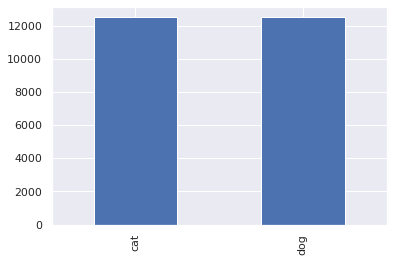

In [7]:
df['Category'].value_counts().plot.bar()

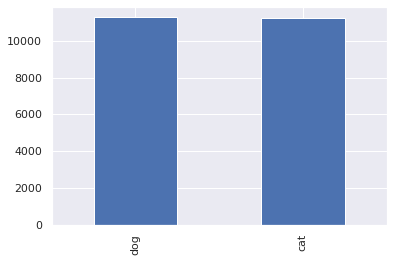

In [8]:
df_train, df_validation = train_test_split(df, test_size=0.1, random_state=18)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_train['Category'].value_counts().plot.bar()
plt.show()

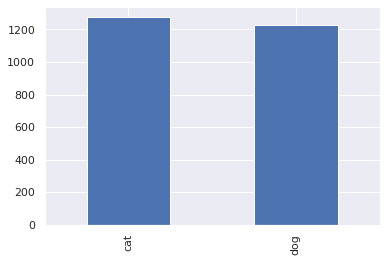

In [9]:
df_validation['Category'].value_counts().plot.bar()
plt.show()

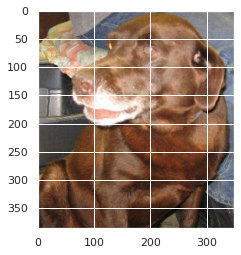

In [10]:
sample = random.choice(df['Image'])
plt.imshow(plt.imread(("./train/"+sample)))
plt.show()

In [11]:
size  = 150
channels = 3
batch = 128
epochs = 5

In [12]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

datagenValidation = ImageDataGenerator(rescale=1./255)

In [13]:
X_train = datagen.flow_from_dataframe(
    df_train, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

X_validation = datagenValidation.flow_from_dataframe(
    df_validation, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


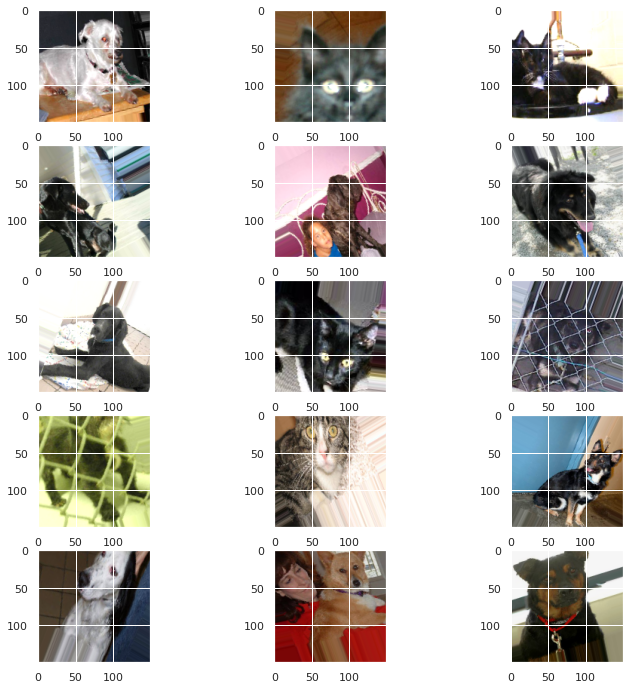

In [14]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in X_train:
        image = X_batch[0]
        plt.imshow(image)
        break
# plt.tight_layout()
plt.show()

In [15]:
checkpoint_filepath = 'best_model.hdf5'
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_learningrate = ReduceLROnPlateau(monitor='val_accuracy', mode='max', min_delta=0.03, patience=3, factor=.5, min_lr=0.00001, verbose=1)
callbacks = [callback_checkpoint, callback_learningrate]

In [16]:
Model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(size,size,channels)),
                    BatchNormalization(),
                    MaxPool2D(2,2),
                    Dropout(0.2),
                 
                    Conv2D(filters=64,  kernel_size=(5,5), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(3,3),
                    Dropout(0.2),
                 
                    Flatten(),
                    
                    Dense(units=200, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                                         
                    Dense(units=2, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    
                    Dense(units=1, activation="sigmoid"),
])
Model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0

In [17]:
history = Model.fit(X_train, validation_data=X_validation, epochs=epochs, callbacks=callbacks,workers = -1)

Epoch 1/5
176/176 [==============================] - 218s 1s/step - loss: 0.6825 - accuracy: 0.5596 - val_loss: 0.6999 - val_accuracy: 0.5096
Epoch 2/5
176/176 [==============================] - 183s 1s/step - loss: 0.6392 - accuracy: 0.6155 - val_loss: 0.6955 - val_accuracy: 0.5564
Epoch 3/5
176/176 [==============================] - 182s 1s/step - loss: 0.6154 - accuracy: 0.6425 - val_loss: 0.6042 - val_accuracy: 0.7232
Epoch 4/5
176/176 [==============================] - 181s 1s/step - loss: 0.5944 - accuracy: 0.6684 - val_loss: 0.5584 - val_accuracy: 0.6912
Epoch 5/5
176/176 [==============================] - 182s 1s/step - loss: 0.5808 - accuracy: 0.6768 - val_loss: 0.5119 - val_accuracy: 0.7444


In [18]:
Model.save("/content/drive/MyDrive/MOD.h5")

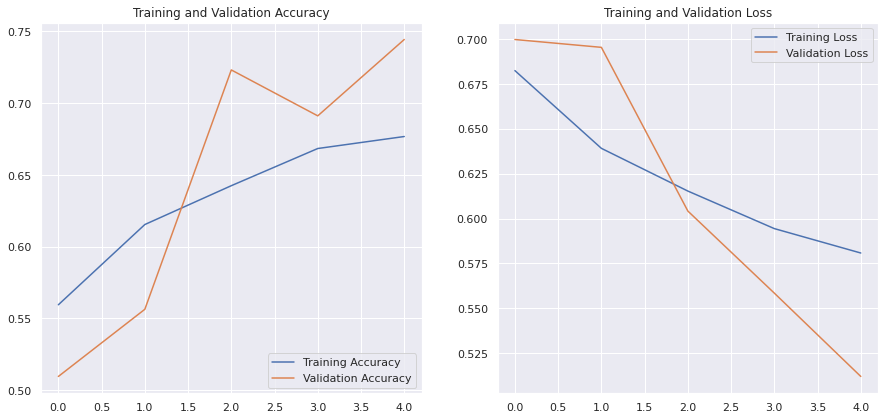

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
Model = tf.keras.models.load_model('best_model.hdf5')

In [21]:
filenames = os.listdir(test_path)
df_test = pd.DataFrame({'Image':filenames})
df_test.head(-5)

,Image
0,7147.jpg
1,1837.jpg
2,8903.jpg
3,6217.jpg
4,276.jpg
...,...
12490,7585.jpg
12491,6193.jpg
12492,4020.jpg
12493,5206.jpg


In [22]:
X_test = datagenValidation.flow_from_dataframe(
    df_test, 
    directory=test_path, 
    x_col='Image',
    y_col=None,
    class_mode=None,
    target_size= (size,size),
    batch_size=batch,
    shuffle=False)

Found 12500 validated image filenames.


In [23]:
X_train.class_indices

{'cat': 0, 'dog': 1}

In [41]:
y_pred = Model.predict(X_validation)

In [42]:
y_pred = np.where(y_pred > .5, "Dog", "Cat")
y_pred

array([['Cat'],
       ['Cat'],
       ['Dog'],
       ...,
       ['Dog'],
       ['Dog'],
       ['Cat']], dtype='<U3')

In [34]:
Model.evaluate(X_validation)

20/20 [==============================] - 7s 325ms/step - loss: 0.5119 - accuracy: 0.7444


[0.5119408369064331, 0.7444000244140625]

In [32]:
def GetXY(gen):
    listX = []
    listY = []
    for i in range(gen.__len__()):
        gennext = gen.next()
        listX.append(gennext[0])
        listY.append(gennext[1])
    x=np.concatenate(listX)
    y=np.concatenate(listY)
    return (x,y)
valX, valY = GetXY(X_validation)

In [50]:
predict = (Model.predict(valX) > 0.5).astype("int32")
print(classification_report(valY,predict))

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      1274
         1.0       0.74      0.73      0.74      1226

    accuracy                           0.74      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.74      0.74      0.74      2500



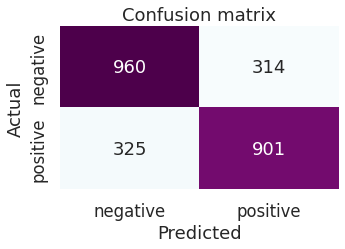

In [51]:
sns.set(style="whitegrid", context='talk')
# Create function so that we could reuse later
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g',cmap = 'BuPu', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});
# Plot confusion matrix
plot_cm(valY,predict)

[[0.552469]]


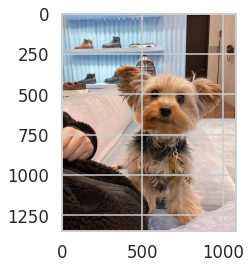

In [53]:
animal_img =  mpimg.imread('/content/drive/MyDrive/IMG_3187.JPG')
plt.imshow(animal_img)

img = cv2.imread('/content/drive/MyDrive/IMG_3187.JPG')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
img = img/255.0

classes = Model.predict(img)
print(classes)